In [1]:
from torchvision import models, transforms
import torch
from PIL import Image
import json

In [2]:
resnet = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)

In [3]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])

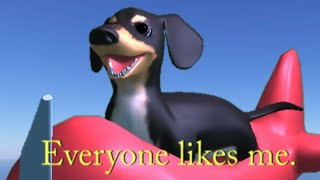

In [8]:
img = Image.open("./data/mqdefault.jpg")
img

In [10]:
img_t = preprocess(img)

In [11]:
batch_t = img_t.unsqueeze(0)

In [12]:
resnet.eval()
out = resnet(batch_t)

In [13]:
softmax = torch.nn.Softmax(dim=0)
probs = softmax(out[0])

In [14]:
with open("./data/imagenet_classes.txt") as f:
    labels = [line.strip() for line in f.readlines()]

In [15]:
_, index = torch.max(out, 1)
labels[index]

'Mexican hairless'

In [17]:
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
f"{labels[index[0]]} {percentage[index[0]].item()}%"

'Mexican hairless 15.175993919372559%'

In [18]:
_, indices = torch.sort(out, descending=True)
[f"{labels[index]}, {percentage[index].item()}" for index in indices[0][:5]]

['Mexican hairless, 15.175993919372559',
 'Saluki, gazelle hound, 10.451492309570312',
 'Doberman, Doberman pinscher, 5.778906345367432',
 'miniature pinscher, 3.5097665786743164',
 'Weimaraner, 2.9326136112213135']